In [41]:
import pandas as pd
path_to_data = "..//data//"

df = pd.read_csv(path_to_data+"pm_data.csv")
sensors_df = pd.read_csv(path_to_data+"sensors.csv")

In [42]:
nan_percentage = df.isnull().mean() * 100

threshold = 95  
filtered_df = df.loc[:, nan_percentage <= threshold]

In [43]:
filtered_sensors = filtered_df.columns[2:-1]
filtered_sensors_df = sensors_df.loc[sensors_df['id'].astype('str').isin(filtered_sensors)]

In [44]:
train_df = pd.read_csv(path_to_data+"raw_train.csv")

## clustering by hand

In [45]:
sensors_df['data_completeness'] = None

for sens in sensors_df['id'].values:
    if str(sens) in train_df.columns:
        sensors_df.loc[sensors_df['id']==sens, "data_completeness"] = train_df[str(sens)].count() / train_df.shape[0]

In [46]:
clusters_0 = {
    0: [1, 4372603],
    1: [2],
    2: [5], 
    3: [6],
    4: [9],
    5: [12],
}

In [47]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class SensorClusterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, clusters, date_column="full_date"):
        """
        Parameters:
        - clusters: dict, mapping cluster IDs to lists of sensor IDs.
        - date_column: str, name of the column containing date information.
        """
        self.clusters = clusters
        self.date_column = date_column

    def fit(self, X, y=None):
        """
        No fitting required for this transformer.
        """
        return self

    def transform(self, X):
        """
        Transforms the input DataFrame to compute mean time series for each cluster.

        Parameters:
        - X: pd.DataFrame, the input time series data with a date column and sensor time series.

        Returns:
        - pd.DataFrame, mean time series for each cluster.
        """
        # Check if the date column exists
        if self.date_column not in X.columns:
            raise ValueError(f"The specified date column '{self.date_column}' does not exist in the DataFrame.")

        # Ensure the date column is set as index temporarily for easier time series operations
        X = X.set_index(self.date_column)

        # Dictionary to hold mean time series for each cluster
        cluster_means = {}

        # Compute mean time series for each cluster
        for cluster_id, sensor_ids in self.clusters.items():
            # Check if all sensor IDs exist in the DataFrame
            sensor_ids = [str(s) for s in sensor_ids]
            missing_sensors = [sensor for sensor in sensor_ids if sensor not in X.columns]
            if missing_sensors:
                raise ValueError(f"The following sensor IDs are missing from the DataFrame: {missing_sensors}")

            # Calculate mean time series for the cluster
            cluster_means[cluster_id] = X[sensor_ids].mean(axis=1)

        # Create a DataFrame for the cluster means
        cluster_means_df = pd.DataFrame(cluster_means)

        # Reset the index to include the date column in the result
        cluster_means_df.reset_index(inplace=True)

        return cluster_means_df

In [48]:
transformer = SensorClusterTransformer(clusters=clusters_0)
cluster_means_df = transformer.transform(df)

### filling nan values

Мы будем заполнять только промежутки в каждом сенсоре

In [49]:
sensors_list = list(sensors_df['id'].values)
sensors_list = [str(s) for s in sensors_list if str(s) in df.columns]

In [50]:
import numpy as np
def rolling_zscore_outlier_removal(series, window=7, z_threshold=3.0):
    """
    Removes (or flags) outliers based on a rolling mean/std approach.
    - series: pd.Series (time indexed)
    - window: rolling window size
    - z_threshold: threshold for z-score
    Returns: A new Series with outliers replaced by NaN (or some other logic).
    """
    rolling_mean = series.rolling(window=window, center=True, min_periods=1).mean()
    rolling_std = series.rolling(window=window, center=True, min_periods=1).std()
    
    z_scores = (series - rolling_mean) / rolling_std
    outliers = z_scores.abs() > z_threshold
    
    # Option 1: Replace outliers with NaN
    cleaned_series = series.mask(outliers, np.nan)
    
    return cleaned_series

In [51]:
def divide_series_into_chunks(series):
    is_nan = series.isna()
    chunks = []
    start_idx = None

    for i, val in enumerate(is_nan):
        if not val and start_idx is None:
            start_idx = i  # Start a new chunk
        elif val and start_idx is not None:
            chunks.append(series[start_idx:i])  # Append the chunk
            start_idx = None

    # Add the last chunk if the series ends without NaNs
    if start_idx is not None:
        chunks.append(series[start_idx:])

    return chunks

from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS  

def fill_nans_with_arima(series, sp=12):
    # Get the chunks of non-NaN data
    chunks = divide_series_into_chunks(series)
    filled_series = series.copy()

    for i in range(len(chunks) - 1):
        current_chunk = chunks[i]
        next_chunk_start = chunks[i + 1].index[0]

        # Ensure datetime types
        last_index = current_chunk.index[-1]
        next_start = next_chunk_start

        # Define training and forecasting horizons
        y_train = current_chunk
        print(y_train)
        
        fh = np.arange(last_index+1, next_start)

        # Fit ARIMA and predict the gap
        forecaster = ExponentialSmoothing(trend="add", seasonal="additive", sp=6)
        forecaster.fit(y_train)
        y_pred = forecaster.predict(fh)

        # Fill the gap in the series
        filled_series.values[last_index+1:next_start] = y_pred

    return filled_series


In [52]:
def fill_missing_with_same_day_values(df, date_col, value_col, direction="both"):
    """
    Fills missing values in a time series by using values from the same day in the next or previous year.
    
    Parameters:
        df (pd.DataFrame): The dataframe containing the time series.
        date_col (str): Column name representing the date.
        value_col (str): Column name representing the values with potential missing data.
        direction (str): Direction to search for values ("next", "previous", or "both"). Default is "both".
    
    Returns:
        pd.DataFrame: The dataframe with missing values filled.
    """
    # Ensure the date column is in datetime format
    df[date_col] = pd.to_datetime(df[date_col])

    # Create an index for fast lookup
    df.set_index(date_col, inplace=True)

    # Fill missing values
    for idx in df[df[value_col].isna()].index:
        year = idx.year
        day_of_year = idx.timetuple().tm_yday

        # Look for the value in the next year
        next_year_date = pd.Timestamp(year + 1, 1, 1) + pd.Timedelta(days=day_of_year - 1)
        previous_year_date = pd.Timestamp(year - 1, 1, 1) + pd.Timedelta(days=day_of_year - 1)

        value_to_fill = None
        if direction in ["next", "both"] and next_year_date in df.index:
            value_to_fill = df.at[next_year_date, value_col]
        
        if direction in ["previous", "both"] and previous_year_date in df.index and pd.isna(value_to_fill):
            value_to_fill = df.at[previous_year_date, value_col]

        # Assign the value if found
        if not pd.isna(value_to_fill):
            df.at[idx, value_col] = value_to_fill

    # Reset the index
    df.reset_index(inplace=True)

    return df

# full pipeline

In [53]:
# Step 1: Clean all sensors
def clean_sensors(dataframe, sensors_list, window=15, z_threshold=3):
    cleaned_data = dataframe.copy()
    for sensor in sensors_list:
        cleaned_data[sensor] = rolling_zscore_outlier_removal(dataframe[sensor], window=window, z_threshold=z_threshold)
    
    return cleaned_data

# Step 2: Apply sensor cluster transformer
def transform_clusters(cleaned_df, clusters):
    transformer = SensorClusterTransformer(clusters=clusters)
    return transformer.transform(cleaned_df)

# Step 3: Fill missing values for all columns in cluster means
def fill_missing_for_all_columns(cluster_means_df, date_col, direction="both"):
    filled_df = cluster_means_df.copy()
    for column in cluster_means_df.columns:
        if column != date_col:
            filled_df = fill_missing_with_same_day_values(
                filled_df, date_col=date_col, value_col=column, direction=direction
            )
    return filled_df

def process_time_series(dataframe, sensors_list, clusters, date_col, window=15, z_threshold=3, direction="both"):
    # Step 1: Clean all sensors
    cleaned_df = clean_sensors(dataframe, sensors_list, window=window, z_threshold=z_threshold)
    
    # Step 2: Calculate cluster means
    cluster_means_df = transform_clusters(cleaned_df, clusters)
    
    # Step 3: Fill missing values
    cluster_means_df_filled = fill_missing_for_all_columns(cluster_means_df, date_col=date_col, direction=direction)
    
    return cluster_means_df_filled

In [54]:
def input_missing_dates(df, date_col="date_time"):
    df = df.set_index(date_col)
    df.index = pd.to_datetime(df.index)
    full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    df = df.reindex(full_range)
    df.index.name = date_col

    return df 

df_dates_filled = input_missing_dates(df, "full_date").reset_index()

In [55]:
processed_df = process_time_series(
    dataframe=df_dates_filled,
    sensors_list=sensors_list,
    clusters=clusters_0,
    date_col="full_date",
    window=60,
    z_threshold=2,
    direction="both"
)

In [56]:
clusters_0 = {
    0: [1, 4372603],
    1: [2],
    2: [5], 
    3: [6],
    4: [9],
    5: [12],
}

In [57]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   full_date  1296 non-null   datetime64[ns]
 1   0          1296 non-null   float64       
 2   1          1282 non-null   float64       
 3   2          1292 non-null   float64       
 4   3          1296 non-null   float64       
 5   4          1289 non-null   float64       
 6   5          1287 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 71.0 KB


<Axes: >

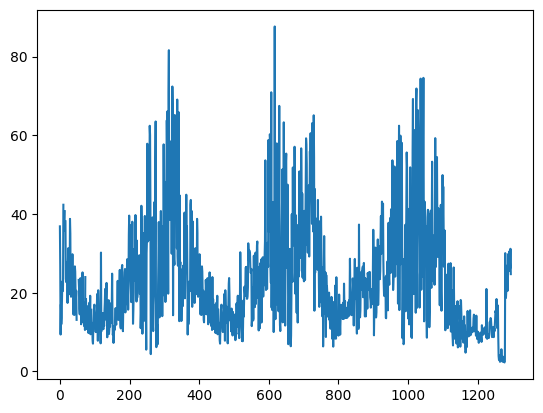

In [58]:
processed_df[5].plot()

In [59]:
processed_df[[0, 1, 2]].to_csv("../data/selected_sensors1_cleaned.csv")

In [60]:
selected_sensors2_cleaned = processed_df.drop(columns=[0, 4, 5])
selected_sensors2_cleaned.rename(columns={
    1: '2',
    2: '5', 
    3: '6',
}, inplace=True)

from functions import holt_winters_imputation_and_expand

selected_sensors2_cleaned['2'] = holt_winters_imputation_and_expand(selected_sensors2_cleaned['2'], 365)
selected_sensors2_cleaned['5'] = holt_winters_imputation_and_expand(selected_sensors2_cleaned['5'], 365)

selected_sensors2_cleaned.to_csv("../data/selected_sensors2_cleaned.csv")

### finally some analysis

In [16]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats

# Define heating season dates
heating_season_dates = [
    ['2016-10-15', '2017-04-10'],
    ['2017-10-15', '2018-04-12'],
    ['2018-10-15', '2019-04-04'],
    ['2019-10-15', '2020-04-20'],
    ['2020-09-28', '2021-04-13'],
]

def is_heating_season(date, heating_season_dates):
    """
    Check if a given date falls within any of the defined heating seasons.
    """
    for start, end in heating_season_dates:
        if pd.to_datetime(start) <= date <= pd.to_datetime(end):
            return True
    return False

def classify_season_and_year(df, heating_season_dates):
    """
    Classify each data point in the DataFrame by 'Season' and 'Year'.
    """
    df.loc[:, 'Season'] = df['date_time'].apply(lambda x: 'Heating' if is_heating_season(x, heating_season_dates) else 'Non-Heating')
    df.loc[:, 'Year']  = df['date_time'].dt.year
    return df

def compute_descriptive_stats_by_season_and_year(df):
    """
    Compute descriptive statistics for each season within each year.
    """
    descriptive_stats = df.groupby(['Season', 'Year'])['value'].describe()
    return descriptive_stats

def perform_anova_by_season(df):
    """
    Perform ANOVA test to determine if there's a significant difference between years within each season.
    """
    anova_results = {}
    for season in df['Season'].unique():
        season_data = df[df['Season'] == season]
        groups = [group['value'].values for name, group in season_data.groupby('Year')]
        anova_result = stats.f_oneway(*groups)
        anova_results[season] = anova_result
    return anova_results

def plot_boxplot_by_season_and_year(df):
    """
    Create a box plot to compare the distribution of values between seasons and years.
    """
    fig = px.box(df, x='Year', y='value', color='Season', title='Distribution of Values by Season and Year')
    fig.show()

# Example usage:
def analyze_seasonal_changes(df):
    df['date_time'] = pd.to_datetime(df['date_time'])
    df = df[df['date_time'].dt.year < 2020].copy()

    df = classify_season_and_year(df, heating_season_dates)
    
    # Compute descriptive statistics
    descriptive_stats = compute_descriptive_stats_by_season_and_year(df)
    print("Descriptive Statistics:\n", descriptive_stats[['mean', 'std']])
    
    # Perform ANOVA tests
    anova_results = perform_anova_by_season(df)
    for season, result in anova_results.items():
        print(f"\nANOVA Result for {season} Season:\nF-statistic: {result.statistic}, P-value: {result.pvalue}")
    
    # Plot box plots
    plot_boxplot_by_season_and_year(df)
  

In [18]:
for i in range(6):
    sngle_sensor_df = processed_df[[i, 'full_date']].copy()
    sngle_sensor_df.rename({i: 'value', 'full_date': "date_time"}, inplace=True, axis=1)
    analyze_seasonal_changes(sngle_sensor_df)

Descriptive Statistics:
                         mean        std
Season      Year                       
Heating     2017  105.711303  56.372808
            2018  114.057724  65.957441
            2019  103.399226  50.928070
Non-Heating 2017   35.111427  16.149908
            2018   35.077553  13.974129
            2019   33.933750  13.184288

ANOVA Result for Heating Season:
F-statistic: 1.5618765189186827, P-value: 0.21089485412748715

ANOVA Result for Non-Heating Season:
F-statistic: 0.40826082014401416, P-value: 0.6650028175961853


Descriptive Statistics:
                        mean        std
Season      Year                      
Heating     2017  62.778189  35.026465
            2018  79.937857  46.242430
            2019  77.800732  46.076942
Non-Heating 2017  19.865593   9.226717
            2018  24.256032   6.684112
            2019  30.940615   8.587431

ANOVA Result for Heating Season:
F-statistic: 5.108229535055165, P-value: 0.006407943972962

ANOVA Result for Non-Heating Season:
F-statistic: nan, P-value: nan


Descriptive Statistics:
                        mean        std
Season      Year                      
Heating     2017  74.248842  54.120810
            2018  99.941116  75.552264
            2019  71.465522  38.445243
Non-Heating 2017  19.055061   7.745408
            2018  19.778648   8.119049
            2019  19.678078   8.557389

ANOVA Result for Heating Season:
F-statistic: nan, P-value: nan

ANOVA Result for Non-Heating Season:
F-statistic: nan, P-value: nan


Descriptive Statistics:
                        mean        std
Season      Year                      
Heating     2017  59.931602  36.908140
            2018  76.934622  50.692121
            2019  59.204485  28.080165
Non-Heating 2017  23.951799   7.960709
            2018  16.328588   6.456716
            2019  14.688722   6.592891

ANOVA Result for Heating Season:
F-statistic: 10.06895681733507, P-value: 5.291589922828879e-05

ANOVA Result for Non-Heating Season:
F-statistic: 93.00880423769527, P-value: 1.3025135324831429e-35


Descriptive Statistics:
                        mean        std
Season      Year                      
Heating     2017  44.449417  23.483325
            2018  56.192960  32.219566
            2019  51.527384  24.130183
Non-Heating 2017  19.361722   9.683433
            2018  17.214707   7.783950
            2019  15.927674   9.151110

ANOVA Result for Heating Season:
F-statistic: 5.663750117655685, P-value: 0.003725514552571475

ANOVA Result for Non-Heating Season:
F-statistic: nan, P-value: nan


Descriptive Statistics:
                        mean        std
Season      Year                      
Heating     2017  28.414949  14.780283
            2018  34.163938  17.634161
            2019  35.784413  15.760777
Non-Heating 2017  17.856662   7.383543
            2018  17.887215   6.867548
            2019  20.070314   7.338821

ANOVA Result for Heating Season:
F-statistic: 6.420883587907731, P-value: 0.0017827841568941304

ANOVA Result for Non-Heating Season:
F-statistic: nan, P-value: nan


Видно, что в 2018 уровень часто выше, чем в 2017 и 2019, однако на большинстве датчиков нету тренда на подъем уровня загрязнения. 